# Neural Network Project
## Part 2: models to compare with neural network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def read_dataset(path):
    data = pd.read_csv(path, engine='python', sep=r',\s*', na_values=['?'])
    
    data.dropna(inplace=True)
    data.drop_duplicates(inplace=True)

    # unnecessary columns
    data.drop(["fnlwgt", "education"], axis=1, inplace=True)
    
    # outliers
    data = data[data["capital-gain"] != 9999]
    
    return data

In [3]:
data = read_dataset('income_evaluation.csv')
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Prepare and split data 

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
X = data.drop(['income'], axis=1)
y = data['income'].values

y[y=='<=50K'] = 0
y[y=='>50K'] = 1

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (30139, 12) y.shape: (30139,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train: {} y_train: {}".format(X_train.shape, y_train.shape))
print("X_test: {} y_test: {}".format(X_test.shape, y_test.shape))

X_train: (24111, 12) y_train: (24111,)
X_test: (6028, 12) y_test: (6028,)


In [7]:
category_data = list(X.select_dtypes(include=['category', 'object']).columns)
numerical_data = list(X.select_dtypes(include=['int64']).columns)
print(category_data)
print(numerical_data)

['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


### Build pipeline

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [9]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]

### pipeliene for numerical data

In [10]:
num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(numerical_data)),
    ("scaler", MinMaxScaler())
])

In [11]:
num_pipeline.fit_transform(X_train)

array([[0.50684932, 0.6       , 0.        , 0.        , 0.47959184],
       [0.21917808, 0.73333333, 0.        , 0.        , 0.39795918],
       [0.20547945, 0.53333333, 0.        , 0.        , 0.39795918],
       ...,
       [0.2739726 , 0.53333333, 0.        , 0.        , 1.        ],
       [0.43835616, 0.53333333, 0.        , 0.        , 0.39795918],
       [0.12328767, 0.53333333, 0.        , 0.        , 0.39795918]])

### pipeline for categorical data

In [12]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(category_data)),
    ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

In [13]:
cat_pipeline.fit_transform(X_train)

array([[0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

### combine pipelines

In [14]:
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

### Training

In [15]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, ExtraTreesClassifier

from scipy.stats.distributions import uniform, randint

In [16]:
kfold = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [17]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', LogisticRegression(n_jobs=-1))])

params = {
    'classifier__C': uniform(0.01, 0.1-0.001),
}

log_reg = RandomizedSearchCV(pipe, params, cv=kfold, return_train_score=True, n_jobs=-1)

log_reg.fit(X_train, y_train)
log_reg.best_params_

{'classifier__C': 0.1039719079656259}

In [18]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', BaggingClassifier(n_jobs=-1, max_features=0.2))
])

params = {
    'classifier__n_estimators': np.random.randint(200, 400, size=10),
}


bag_clf = RandomizedSearchCV(pipe, params, cv=kfold, return_train_score=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
bag_clf.best_params_

{'classifier__n_estimators': 363}

In [19]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', ExtraTreesClassifier(n_jobs=-1))
])

params = {
    'classifier__n_estimators': np.random.randint(200, 400, size=10),
    'classifier__max_leaf_nodes': np.random.randint(25, 40, size=10)
    
}

extra_tree_clf = RandomizedSearchCV(pipe, params, cv=kfold, return_train_score=True, n_jobs=-1)

extra_tree_clf.fit(X_train, y_train)
extra_tree_clf.best_params_

{'classifier__n_estimators': 264, 'classifier__max_leaf_nodes': 34}

In [20]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', KNeighborsClassifier(n_jobs=-1, weights='distance'))
])

params = {
    'classifier__n_neighbors': np.random.randint(1, 10, size=10),
}

knn_clf = RandomizedSearchCV(pipe, params, cv=kfold, return_train_score=True, n_jobs=-1)

knn_clf.fit(X_train, y_train)
knn_clf.best_params_

{'classifier__n_neighbors': 9}

In [21]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', VotingClassifier(
                estimators=[
                    ('lr', LogisticRegression(n_jobs=-1)), 
                    ('rf', RandomForestClassifier(n_jobs=-1, max_samples=0.1)), 
                    ('bag', BaggingClassifier(n_jobs=-1, max_features=0.1))
                ],
                voting='soft')
    )
])

params = {
    'classifier__lr__C': uniform(0.01, 0.1-0.001),
    'classifier__rf__n_estimators': np.random.randint(40, 80, 10),
    'classifier__bag__n_estimators': np.random.randint(200, 400, size=10),
}

soft_voting_clf = RandomizedSearchCV(pipe, params, cv=kfold, return_train_score=True, n_jobs=-1)

soft_voting_clf.fit(X_train, y_train)
soft_voting_clf.best_params_

{'classifier__bag__n_estimators': 261,
 'classifier__lr__C': 0.062082203216059596,
 'classifier__rf__n_estimators': 72}

### Test

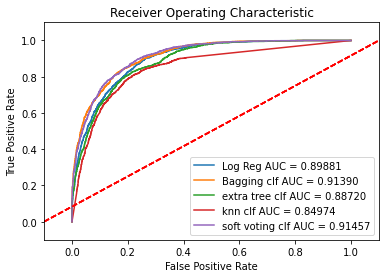

In [22]:
models = []
models.append(('Log Reg', log_reg.best_estimator_))
models.append(('Bagging clf', bag_clf.best_estimator_))
models.append(('extra tree clf', extra_tree_clf.best_estimator_))
models.append(('knn clf', knn_clf.best_estimator_))
models.append(('soft voting clf', soft_voting_clf.best_estimator_))


method, precision_score, recall_score, f1_score, accuracy_score = [], [], [], [], []

for name, model in models:
    method.append(name)
    y_pred = model.predict(X_test)
    
    precision_score.append(metrics.precision_score(y_test, y_pred))
    recall_score.append(metrics.recall_score(y_test, y_pred))
    f1_score.append(metrics.f1_score(y_test, y_pred))
    accuracy_score.append(metrics.accuracy_score(y_test, y_pred))
    
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
 

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = '%s AUC = %0.5f' % (name, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([-0.1, 1.1], [0, 1],'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()

In [23]:
d = {'Method': method,
    'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,Log Reg,0.734660,0.574206,0.644598,0.837923
1,Bagging clf,0.952507,0.233960,0.375650,0.800929
2,extra tree clf,0.742498,0.497084,0.595497,0.827140
3,knn clf,0.685368,0.585872,0.631726,0.825149
4,soft voting clf,0.819895,0.507453,0.626902,0.845388
